<h1 align="center">Class Project</h1> 
<h3 align="center">Data Mining</h3>
<h3 align="center">EN.625.740.81.FA23</h3>
<h3 align="center">Eric Farish</h3>

This is the COVID-19 analysis notebook.

The purpose of this analysis is to determine the contributing factors of COVID mortality during a time-period in the United States spanning January 2020 to June 2021. This analysis will also try to determine an order of importance for those factors. The purpose of this analysis is not produce an optimize predictive model. It is focused on understanding the contributed factors to COVID deaths. As these will be regression models, `RMSE` will be used to evaluate the quality of each model. 

Below is the index of the model developed for this analysis.

* [Perform ETL and Load Data](#elt)
* [Models](#models)
    * [Null Model](#modelnull)
    * [Model 1 - Linear Regression](#model1)
    * [Model 2 - Random Forest Regression](#model2)
    * [Model 3 - Decision Tree Regression](#model3)
    * [Model 4 - Multi-layer Perceptron](#model4)
* [Summary](#summary)


In [2]:
import random
import numpy as np
import util

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

seed = 0

# Use this to re-import a library without restarting the kernel.
#import importlib
#importlib.reload(util)

<a class="anchor" id="etl"></a>
# Perform ETL and Load Data

The data used for this analysis contains daily observations for each of the 3142 US counties and covers the time-period of January 2020 through June 2021. Per the [abstract](#https://www.sciencedirect.com/science/article/pii/S2352340921006429) of the paper this data was released with, the data was collected from public online databases. There are temporal and fixed variables (the values for these are the same for all observations). The target variable `covid_19_deaths`. 

The data dictionary is [here](https://www.sciencedirect.com/science/article/pii/S2352340921006429#tbl0001) and the data itself is located [here](https://github.com/network-and-Data-Science-IUT/covid-19/tree/master/USA%20covid-19%20data).

There are 992,266 records with no missing values as the authors imputed missing data. The observations for 1181 counties were removed due to missing data that could not be imputed. This leaves data for 1961 counties. There are over 46 variables in the data file, I chose to use 31 of them based on research that can be viewed in the paper accompanying this distribution.

The SQL below aggregates the daily data found in the file "imputed-data.rar" to the county level. Therefore, the 992,266 daily county detail records are aggregated to 1961 aggregate county records. In addition, the following transformation were done.

* The categorical variables for social GPAs are converted to numerical values and averaged over the period. For example, a grade of “A” was converted to 4.0, “A-” to 3.7, etc.
* Temporal variables were averaged during aggregation.
* Fixed variables had their "max" value taken during aggregation.
* The target variable `covid_19_deaths` is transformed into a new target variable `covid_19_deaths_per_100k`. I thought this variable would be more comparable between counties. 

Below the ELT is run and the data loaded.

In [3]:
import pandas as pd
import sqlite3
#import COVID_ETL_v3 as etl

#etl.createCOVIDDB()
conn = sqlite3.connect('./COVID_DATA.db')
covid = pd.read_sql_query("SELECT * from COVID_DATA", conn)
conn.close()
data = util.pre_process(covid)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   percent_of_smokers                  1961 non-null   float64
 1   percent_of_diabetes                 1961 non-null   float64
 2   median_household_income             1961 non-null   int64  
 3   less_than_high_school_diploma       1961 non-null   float64
 4   high_school_diploma_only            1961 non-null   float64
 5   some_college_or_higher              1961 non-null   float64
 6   population_density                  1961 non-null   float64
 7   social_distance_gpa                 1961 non-null   float64
 8   social_distance_gpa_visitation      1961 non-null   float64
 9   social_distance_gpa_encounters      1961 non-null   float64
 10  social_distance_gpa_travel          1961 non-null   float64
 11  percent_of_vaccinated_residents     1961 no

## Create Training and Test Datasets

The data is split into training and test datasets.

In [4]:
from sklearn.model_selection import train_test_split
import patsy

set_seed(seed)

formula_1 = util.get_formula(data) 
y, X = patsy.dmatrices(formula_1, data, return_type="dataframe")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

Below is the distribution of deaths per county during the time period.

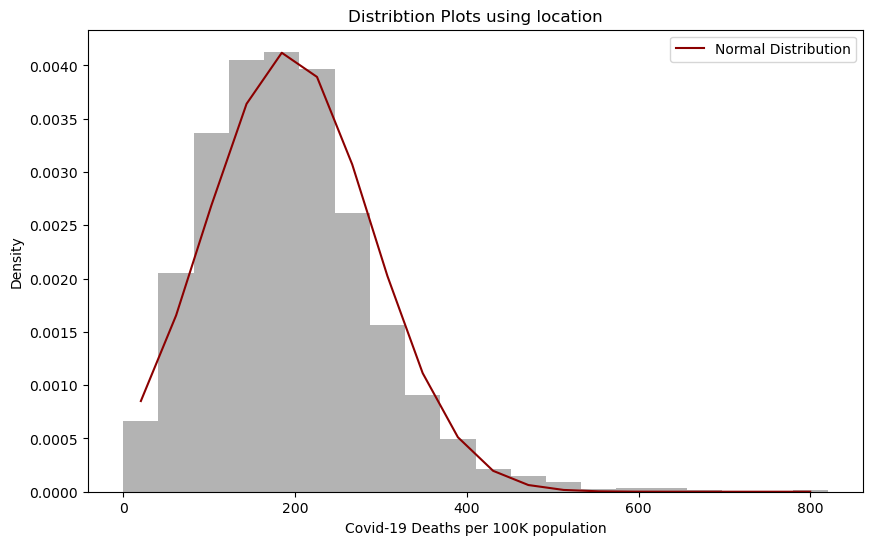

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as stats

chartColor = 'DimGray'
chartAlpha=0.5

dp100k=data.covid_19_deaths_per_100k
figure = plt.figure(figsize=(10,6))

values, base = np.histogram(dp100k, bins=20, density=True)
axes = figure.add_subplot(1,1,1)
n, bins, patches = axes.hist(dp100k,bins=base,color=chartColor,density=True,alpha=chartAlpha) 
xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]
#normal
normLoc, normScale = stats.norm.fit(dp100k)
ys =  [stats.norm.pdf(x=k,loc=normLoc, scale=normScale) for k in xs]
axes.plot(xs,ys, color="darkred",label="Normal Distribution")

axes.set_title(f"Distribtion Plots using location")
axes.set_xlabel(f"Covid-19 Deaths per 100K population")
axes.set_ylabel(f"Density")
axes.legend()
plt.show()
plt.close()

This data follows a right-skewed normal distribution.

<a class="anchor" id="models"></a>
# Models

Four Model will be used to determine the factors for COVID-19 deaths during this time period.

- A Null Model whose standard error all other models must surpass to be part of the analysis.
- A Ordinary-Least-Squares (OLS) model.
- A Decision Tree Model.
- A Random Forest Model.

These models where chosen for the ability to determine feature importance from the data.

<a class="anchor" id="modelnull"></a>
## Null Model

Below is the Null model. This model takes the average of the COVID-19 deaths per county and uses that as the prediction. The standard error of this model will be compared to the RMSE statistics of the following models. All models must have a RMSE lower than the standard deviation of the Null Model.

In [6]:
mean_deaths = y_train.values.mean()
std_deaths  = y_train.values.std()
print("COVID Deaths per 100K Location: {0:.2f}, Standard Error: {1:.2f}".format(mean_deaths, std_deaths))

COVID Deaths per 100K Location: 192.16, Standard Error: 96.77


<a class="anchor" id="model1"></a>
## Model 1 - Linear Regression Model

The linear model will be repeatedly fitted to remove statistically insignificant predictors and address model issue like multi-collinearity. In addition, diagnostic tests will be done to make sure the models don't break the OLS regression assumptions below:

- A linear relationship between response and predictor variables.
- The homoscedasticity of residuals for different levels of the predictor variables.
- The Independence (no Autocorrelation) of residuals.
- The residuals follow a normal distributed.
- No Multicollinearity between predictor variables.

## Build 

The `statsmodels` library will be used for this model.

Below is the first build using all the predictors.

In [7]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     covid_19_deaths_per_100k   R-squared:                       0.409
Model:                                  OLS   Adj. R-squared:                  0.397
Method:                       Least Squares   F-statistic:                     34.24
Date:                      Thu, 16 Nov 2023   Prob (F-statistic):          3.28e-151
Time:                              23:16:17   Log-Likelihood:                -8982.5
No. Observations:                      1568   AIC:                         1.803e+04
Df Residuals:                          1536   BIC:                         1.820e+04
Df Model:                                31                                         
Covariance Type:                  nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

The first model has a number of statistically insignificant predictors. The code below removes them from the model.

In [8]:
X_train_2 = util.remove_insignificant(X_train, model)
model = sm.OLS(y_train, X_train_2).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     covid_19_deaths_per_100k   R-squared:                       0.371
Model:                                  OLS   Adj. R-squared:                  0.366
Method:                       Least Squares   F-statistic:                     70.48
Date:                      Thu, 16 Nov 2023   Prob (F-statistic):          4.88e-146
Time:                              23:16:19   Log-Likelihood:                -9031.0
No. Observations:                      1568   AIC:                         1.809e+04
Df Residuals:                          1554   BIC:                         1.817e+04
Df Model:                                13                                         
Covariance Type:                  nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

All the variables are significant. The F-statistic shows that, overall, the model is statistically significant. Lets now check for multicollinearity.

### Multicollinearity

The variance inflation factor (VIF) will be used to check for multi-collinearity in the remaining predictors. This statistic quantifies the extent of correlation between one predictor and the other predictors in a model. Predictors with high VIF values indicate correlation between the variables. Significant multicollinearity makes it difficult to accurately assess the contribution of predictors to a model. This is due to coefficient estimates and p-values in the regression output being unreliable. Per `An Introduction to Statistical Learning` (James et al, 2nd edition), VIF values exceeding 5 indicates a problematic amount of collinearity. Below the VIF statistics per predictor are calculated.

__NOTE: Per the implementor, the statsmodel variance_inflation_factor expects [ the design matrix of or for a regression that already includes a constant.](https://github.com/statsmodels/statsmodels/issues/2376#issuecomment-97167385)__

In [9]:
vif_data = util.get_VIF(X_train_2)
vif_data.sort_values(by=['VIF'], ascending=False)

,feature,VIF
0,Intercept,699.937613
11,age_80_84,3.376282
3,median_household_income,3.135267
10,age_65_69,3.037059
12,age_85_or_higher,2.746496
5,social_distance_gpa_visitation,2.410348
13,workplaces_mobility_percent_change,2.380468
8,age_30_34,2.290859
9,age_55_59,2.246489
7,age_20_24,2.227831


Most of the multicollinearity is coming from the intercept term and, thus, can be ignored. Based on the results or the predictor variables, there is a moderate but not problematic amount of collinearity in the design matrix. 

Moving on, lets now check for the normality of the model residuals.
 
### Residuals vs fitted plot

Residual plots are useful for identifying non-linearity and heteroscedasticity. Also included in this plot is a red line which indicates the fit of a locally weighted scatterplot smoothing (lowess), a local regression method. It can be interpreted as follows: The fit is almost equal to the dotted horizontal line where the residuals are zero. This is an indication for a linear relationship. For non-linear relationships, the red line will deviate strongly from the horizontal line.

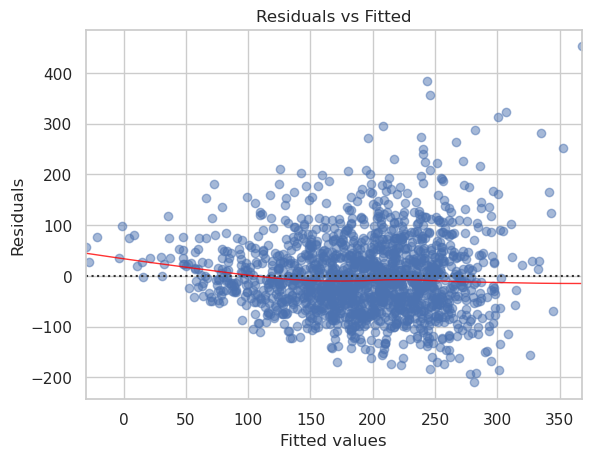

In [12]:
import seaborn as sns
sns.set(style="whitegrid")

plot = sns.residplot(x=model.fittedvalues, y=y_train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot.set_title('Residuals vs Fitted');plot.set_xlabel('Fitted values');plot.set_ylabel('Residuals');

There is some indication of non-normal distribution of residuals. But the deviation does not appear to be strong. Lets take another view of the same issues.

### Normal Q-Q Plot

This plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line.

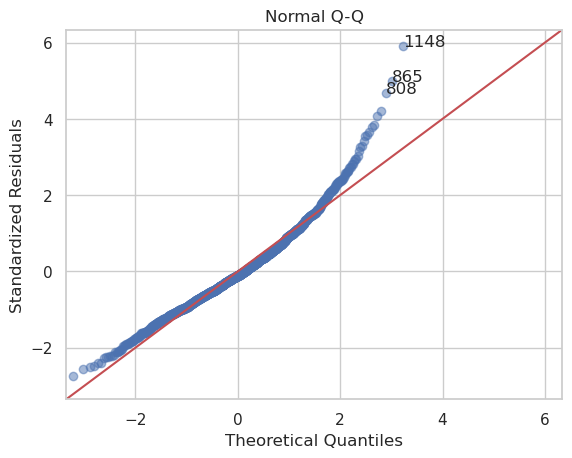

In [13]:
from statsmodels.graphics.gofplots import ProbPlot
# normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));


There appears to be significant deviation from normality in the upper quantiles of COVID deaths. 

In the code below, I try to address this.

I'll first do pair-wise plots of the individual variable's relationship with the dependent variable

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
data_pp = X_train_2[X_train_2.columns[1:]].copy()
data_pp['y'] = y_train[['covid_19_deaths_per_100k']].values.ravel()

<Figure size 1500x800 with 0 Axes>

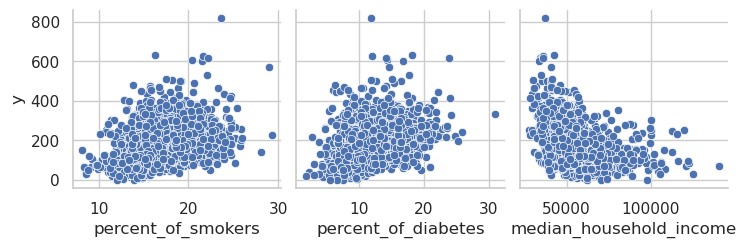

In [16]:
plt.figure(figsize=(15,8))
r = sns.pairplot(data=data_pp,
                  y_vars=['y'],
                  x_vars=['percent_of_smokers', 'percent_of_diabetes', 'median_household_income'])

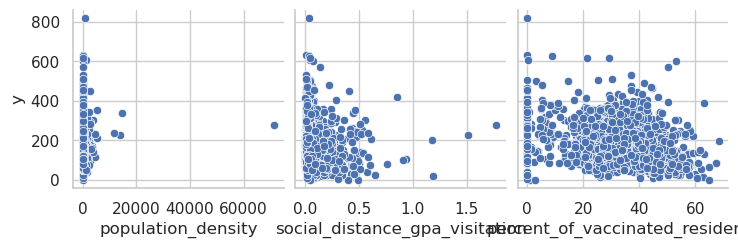

In [17]:
r = sns.pairplot(data=data_pp,
                  y_vars=['y'],
                  x_vars=['population_density', 'social_distance_gpa_visitation','percent_of_vaccinated_residents'])

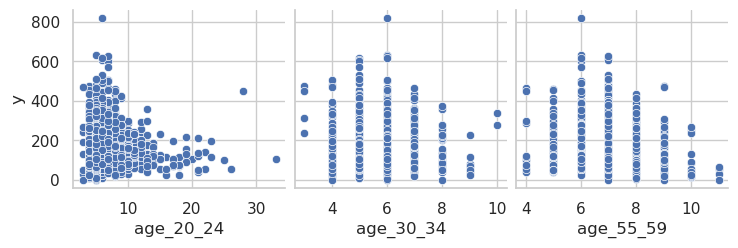

In [18]:
r = sns.pairplot(data=data_pp,
                  y_vars=['y'],
                  x_vars=['age_20_24', 'age_30_34','age_55_59'])

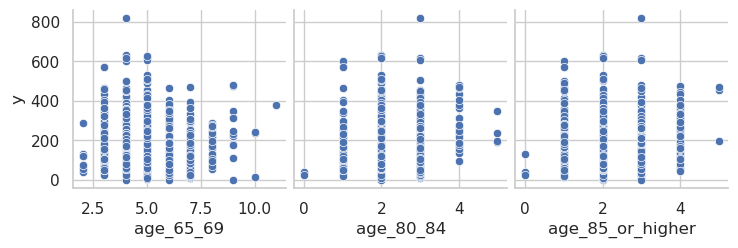

In [19]:
r = sns.pairplot(data=data_pp,
                  y_vars=['y'],
                  x_vars=['age_65_69', 'age_80_84', 'age_85_or_higher'])

It appears `median_household_income` and `age_20_24` could benefit form a `log` transformation. This is done below.

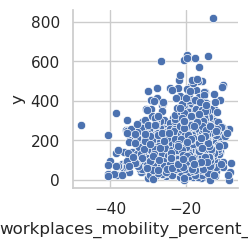

In [20]:
r = sns.pairplot(data=data_pp,
              y_vars=['y'],
              x_vars=['workplaces_mobility_percent_change'])

Based on the pair-wise plots above, `median_household_income` and `age_20_24` appear to have  logarithmic relationship with the response variable. Therefore, a log transformation is applied to these two variables and the model refitted. 

In [21]:
X_train_3 = X_train_2.copy()
X_train_3['log_mhi'] = np.log(X_train_3.median_household_income)
X_train_3 = X_train_3.drop(['median_household_income'],axis=1)

X_train_4 = X_train_3.copy()
X_train_4['log_age_20_24'] = np.log(X_train_4.age_20_24)
X_train_4 = X_train_4.drop(['age_20_24'],axis=1) 

model = sm.OLS(y_train, X_train_4).fit()

Lets plot the Normal Q-Q again.

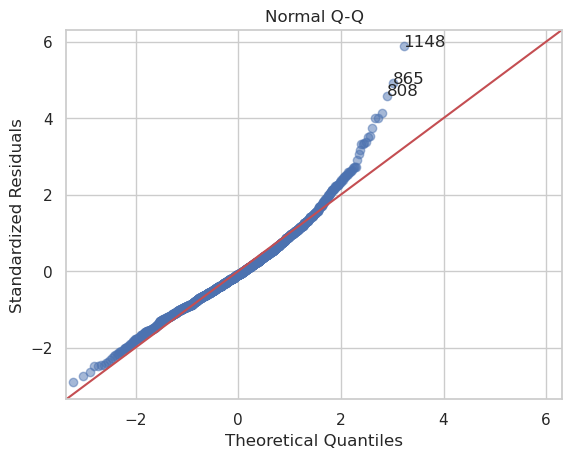

In [22]:
util.plot_norm_qq(model)

The impact of the two transformations is marginal, at best. The transformations are not helping. 

Below, I try to determine if the residuals deviation from normality is significant using a Shapiro-Wilk test. This tests the null hypothesis that the data was drawn from a normal distribution. I retrain using the original dataset and calculate a the test test statistic and p-value.

In [23]:
from scipy import stats

model = sm.OLS(y_train, X_train_2).fit()

model_norm_residuals = model.get_influence().resid_studentized_internal
stats.shapiro(model_norm_residuals)

ShapiroResult(statistic=0.9656657576560974, pvalue=7.802665471241999e-19)

The very small p-value provides evidence that the assumption of normality of the residuals can be rejected.

My last attempt was creating a log-linear model by applying a natural-log transformation to the response variable. Below are the results.

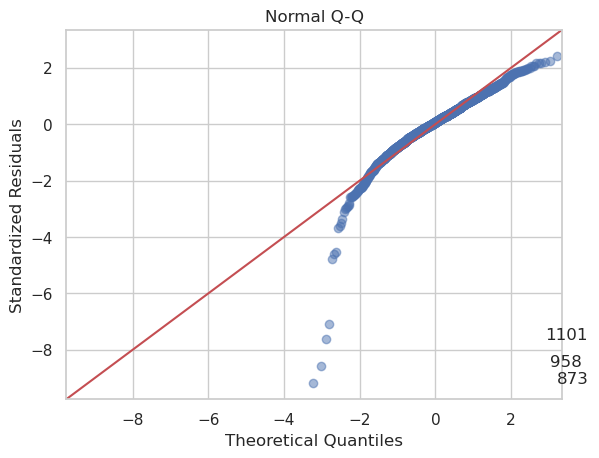

In [24]:
y_log = [x if x == 0 else np.log(x) for x in y_train.values.ravel()]
model = sm.OLS(y_log, X_train_2).fit()
util.plot_norm_qq(model)

This appears to create even more problems. 

The non-normality of the residuals (and my inability to fix it) is a violation of the OLS assumption of normality of residuals. The impact of this violation results in the confidence intervals and p-values for parameters estimations not being reliable and, therefore, not a good model to use for feature importance for this dataset. 

Despite this, I will still evaluate model's quality by examining its `RMSE`.

## Model Evaluation
 
 Below, 30 averages of 10-fold cross-validation is performed. I did this 30 times in an attempt to use the Central Limit Theorem in to get normally distributed performance metrics. Below are the results.

In [25]:
##### set_seed(seed)
util.do_lm_cross_validation(util.SMWrapper(sm.OLS), X_train_2, y_train)

0 tests done...
5 tests done...
10 tests done...
15 tests done...
20 tests done...
25 tests done...
All 30 done.
Avg. RMSE -78.48 with SD 0.4616, Avg. R2 0.32 with SD 0.0098


Below, I calculate the performance on the help out test dataset.

In [26]:
from sklearn.metrics import r2_score, mean_squared_error

model = sm.OLS(y_train, X_train_2).fit()
y_pred = model.predict(X_test[X_train_2.columns])
print(f'R2 Score: {r2_score(y_test.values.ravel(), y_pred.values):.4f}' )
print(f'RMSE: {np.sqrt( mean_squared_error( y_test.values.ravel(), y_pred.values) ):.4f}' )

R2 Score: 0.3185
RMSE: 78.9931


The model performance is better than the Null Model.

<a class="anchor" id="model1_summary"></a>
### Summary

I could not create an OLS model that satisfied the assumptions of OLS. In particular, the normality of residuals assumption appears to be violated. This may also indicate the relationship between the predictors and the response may not be linear. Therefore, for this dataset, OLS is not a good model to use for feature importance. 

<a class="anchor" id="model2"></a>
## Model 2 - Random Forest Regressor

Decision Trees and Random Forest regressors do not make the assumptions that OLS regression does. In particular, the linear relationship between the predictors and the target variable. It appears their only assumptions are that there is some predictive power for the features in the model and that the decision trees are not correlated. Based on my analysis, I think here is predictive value in the features. As for the correlation between trees, the Random Forest algorithm address this by choosing `m` variables randomly to build each estimator tree.

A drawback of Decision Trees and Random Forest models is that they can easily over-fit the data. To avoid this, 30 averages of 10-fold cross validation will be performed. 
 
Both Decision Trees and Random Forest track the importance of features in reducing the entropy present in the data. After an optimized tree is built, the importance of each feature will be evaluated.  

The Random Forest model is fitted first.
 
<a class="anchor" id="buildm2"></a>
### Model Build

A random forest model was optimized using randomized search grid cross-validation. $RMSE$ is be the performance metric.  

In [27]:
set_seed(seed)
y, X = patsy.dmatrices(formula_1 + ' - 1'  , data, return_type="dataframe") # The "-1" tells patsy to remove the intercept.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [28]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = seed )
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 20)]
max_features = ['sqrt', 'log2',  None]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
max_leaf_nodes = [None,10,20,30]
#criterion = ['squared_error', 'absolute_error'] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'max_leaf_nodes': max_leaf_nodes}
               #'criterion': criterion}

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=4, random_state=seed, n_jobs = 7)
# Fit the random search model
r = rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=5, n_estimators=73;, score=0.382 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=67;, score=0.342 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=40, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=10, n_estimators=25;, score=0.440 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=40, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=10, n_estimators=25;, score=0.368 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10, n_estimators=78;, score=0.326 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=90, max_features=log2, max_l

Lets take a look at the parameters of the best estimator.

In [29]:
rf_random.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 40,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 88,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


### Model Evaluation

Below, 30 averages of 10-fold cross validations are performed. 

In [30]:
%%time
set_seed(seed)
util.do_lm_cross_validation(rf_random.best_estimator_, X_train, y_train.values.ravel(), n_jobs=-1)

0 tests done...
5 tests done...
10 tests done...
15 tests done...
20 tests done...
25 tests done...
All 30 done.
Avg. RMSE -72.05 with SD 0.2697, Avg. R2 0.43 with SD 0.0056
CPU times: user 264 ms, sys: 111 ms, total: 375 ms
Wall time: 18.3 s


Lets see how the final model does on the test dataset.

In [31]:
%%time
from sklearn.metrics import r2_score, mean_squared_error

set_seed(seed)
y_true = np.ravel(np.array(y_test))
y_pred = rf_random.best_estimator_.predict(X_test)
print('Random Forest Regressor,  R^2: %f' % round(rf_random.best_estimator_.score(X_test, y_test.values.ravel() ),2) )
print('Random Forest Regressor, RMSE: %f' % round(np.sqrt( mean_squared_error(y_true,y_pred)),2) ) 

Random Forest Regressor,  R^2: 0.460000
Random Forest Regressor, RMSE: 70.230000
CPU times: user 17.1 ms, sys: 0 ns, total: 17.1 ms
Wall time: 16.3 ms


For both the CV and test data, the `R^2` and `RMSE` is superior to the Null and OLS models.

### Model Interpretation

Each estimator in the random forest calculate the importance of a feature according to its ability to increase the pureness of the decision tree leaves. The random forest algorithm takes this calculation, averages them across the trees and then normalizes the values. Below is the plot for the random forest regression estimator features importance. 

In [32]:
%%time
set_seed(seed)
estimator = rf_random.best_estimator_.fit(X_train,y_train.values.ravel())
feature_index = estimator.feature_importances_.argsort()
feature_index = np.flip(feature_index)
feature_importance = estimator.feature_importances_[feature_index]

CPU times: user 336 ms, sys: 411 µs, total: 336 ms
Wall time: 335 ms


In [33]:
print(f'Importance of the first 10 features as a percentage of the total: \
{sum(feature_importance[:10]):.2f}%')

Importance of the first 10 features as a percentage of the total: 0.65%


In [34]:
feature_importance[:10]

array([0.10574233, 0.09881322, 0.07456925, 0.06188152, 0.06026234,
       0.05758897, 0.05512742, 0.05100888, 0.04510604, 0.04464637])

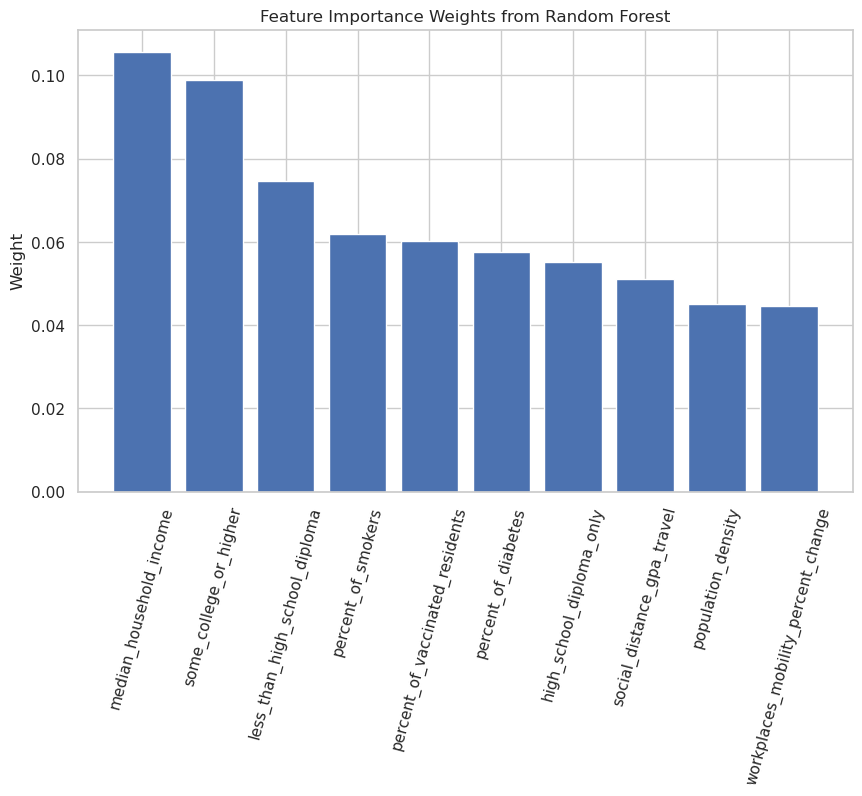

In [35]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(X_train.columns[feature_index[:10]], feature_importance[:10])
axes.set_xticks(np.arange(len(X_train.columns[feature_index[:10]])))
axes.set_xticklabels(X_train.columns[feature_index[:10]], rotation = 75)
axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Random Forest")
plt.show()
plt.close()

The 5 most import features are college education, income, vaccination status, population density, and smoking. They account for 75% of the impurity reduction of the model.

The impurity-based feature importance ranks the numerical features to be the most important features. The impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set.

As an alternative, the permutation importances of random forest are computed on a held out test set. Permuting the values of these features will identify the features whose removal leads to most decrease in the accuracy score of the model on the test set.

Per `scikit-Learn` documentation: The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2, n_estimators=46;, score=0.391 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=67;, score=0.387 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.389 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=40, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.127 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.405 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, n_estima

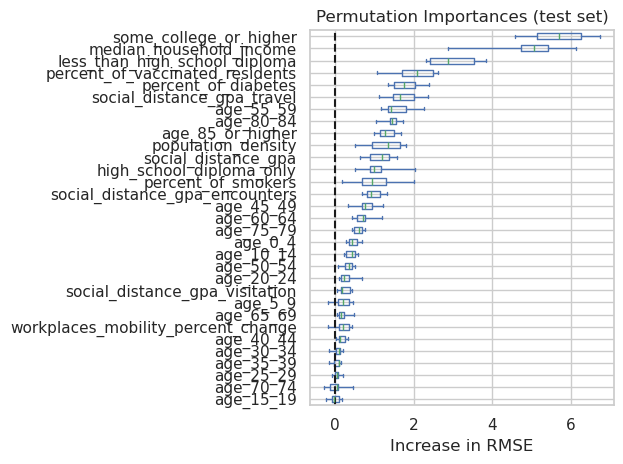

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

rf = Pipeline(
    [
        ("regressor", estimator)
    ]
)
rf.fit(X_train, y_train.values.ravel())

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1, scoring = 'neg_root_mean_squared_error'
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Increase in RMSE")
ax.figure.tight_layout()

In [39]:
result.importances_mean[np.flip(np.abs(result.importances_mean).argsort())]

array([ 5.67666923e+00,  4.93278849e+00,  2.98410527e+00,  2.05056116e+00,
        1.80303848e+00,  1.72439760e+00,  1.56975057e+00,  1.43385570e+00,
        1.30237375e+00,  1.27811088e+00,  1.12736105e+00,  1.08509350e+00,
        1.02484050e+00,  9.60196718e-01,  7.80455392e-01,  7.23821959e-01,
        5.95068290e-01,  4.57428381e-01,  3.99664723e-01,  3.26692737e-01,
        2.68424408e-01,  2.29133382e-01,  1.94846434e-01,  1.81870525e-01,
        1.80628779e-01,  1.59012919e-01,  7.20622067e-02,  4.89846902e-02,
        4.72115357e-02, -8.45367136e-03,  4.03997621e-03])

These results mostly agree with the top 10 features obtained from the training data. However, the feature importance from the test data has the feature `age_80_84` in its top 10 where the training data did not. 

<a class="anchor" id="model3"></a>
## Model 3 - Decision Tree Regressor

Below a single decision tree is optimized using a randomized Grid Search and the feature importance reviewed.

### Build

In [40]:
from sklearn import tree

rf_random_dt = random_grid.copy()
rf_random_dt.pop('n_estimators')
rf_random_dt.pop('bootstrap')

dt = tree.DecisionTreeRegressor(random_state=seed)

rf_random_dt = RandomizedSearchCV(estimator = dt, 
                               param_distributions = rf_random_dt, 
                               n_iter = 300, cv = 3, verbose=4, random_state=seed, n_jobs = 7)
# Fit the random search model
r = rf_random_dt.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 3/3] END max_depth=60, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=2;, score=0.166 total time=   0.0s
[CV 3/3] END max_depth=80, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5;, score=0.188 total time=   0.0s
[CV 3/3] END max_depth=None, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_samples_split=2;, score=0.182 total time=   0.0s
[CV 3/3] END max_depth=40, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2;, score=-0.134 total time=   0.0s
[CV 1/3] END max_depth=100, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5;, score=0.109 total time=   0.0s
[CV 1/3] END max_depth=90, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=10;, score=0.210 total time=   0.0s
[CV 3/3] END max_depth=100, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_samples_spli

In [41]:
rf_random_dt.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 10,
 'max_features': None,
 'max_depth': 50}

### Model Evaluation

In [42]:
dt = rf_random_dt.best_estimator_ 
y_true = np.ravel(np.array(y_test))
y_pred = dt.predict(X_test)
print('Decision Tree Regressor,  R^2: %f' % round(dt.score(X_test, y_test.values.ravel() ),2) )
print('Decision Tree Regressor, RMSE: %f' % round(np.sqrt( mean_squared_error(y_true,y_pred)),2) ) 

Decision Tree Regressor,  R^2: 0.210000
Decision Tree Regressor, RMSE: 84.870000


In [43]:
%%time
util.do_lm_cross_validation(dt, X_train.copy(), y_train.copy().values.ravel())

[CV 1/3] END max_depth=70, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2;, score=0.222 total time=   0.0s
[CV 2/3] END max_depth=90, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=2;, score=0.110 total time=   0.0s
[CV 3/3] END max_depth=90, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=2;, score=0.080 total time=   0.0s
[CV 1/3] END max_depth=70, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5;, score=0.186 total time=   0.0s
[CV 2/3] END max_depth=60, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_samples_split=10;, score=0.190 total time=   0.0s
[CV 3/3] END max_depth=60, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_samples_split=10;, score=0.188 total time=   0.0s
[CV 1/3] END max_depth=100, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_samples_split=2;, score=0.135 total time=   0.0s
[CV 2/3] END max_depth=90, max_

This `RMSE` of the Decision Tree model is inferior to the OLS and Random Forest models but better than the Null Model.

### Model Interpretation

The feature importance of this model will be obtained using the same approach as was used for the Random Forest model.

In [44]:
feature_index = dt.feature_importances_.argsort()
feature_index = np.flip(feature_index)
feature_importance = dt.feature_importances_[feature_index]
print(f'Importance of the first 10 features as a percentage of the total: \
{sum(feature_importance[:10]):.2f}%')

Importance of the first 10 features as a percentage of the total: 1.00%


In [45]:
feature_importance[:10]

array([0.54577753, 0.22701129, 0.11630399, 0.04439172, 0.03561158,
       0.03090389, 0.        , 0.        , 0.        , 0.        ])

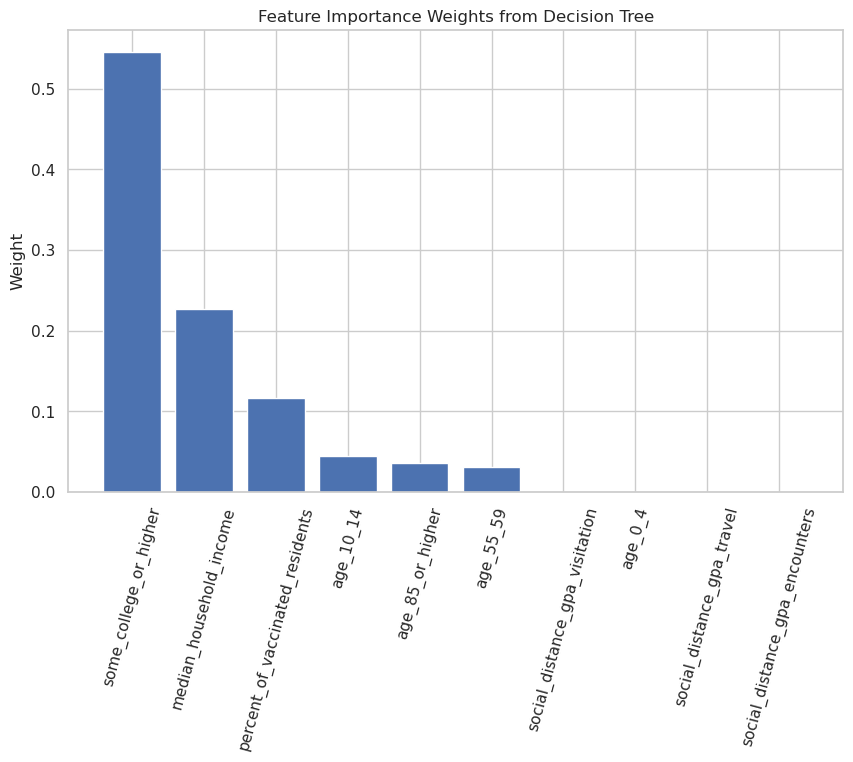

In [46]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(X_train.columns[feature_index[:10]], feature_importance[:10])
axes.set_xticks(np.arange(len(X_train.columns[feature_index[:10]])))
axes.set_xticklabels(X_train.columns[feature_index[:10]], rotation = 75)
axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Decision Tree")
plt.show()
plt.close()

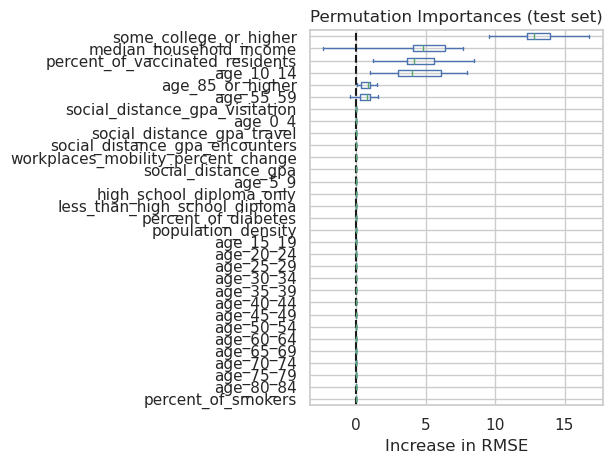

In [47]:
rf = Pipeline(
    [
        ("regressor", dt)
    ]
)
rf.fit(X_train, y_train)

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1, scoring = 'neg_root_mean_squared_error'
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Increase in RMSE")
ax.figure.tight_layout()

In [48]:
X_train.columns[np.flip(np.abs(result.importances_mean).argsort())]

Index(['some_college_or_higher', 'median_household_income',
       'percent_of_vaccinated_residents', 'age_10_14', 'age_85_or_higher',
       'age_55_59', 'social_distance_gpa_visitation', 'age_0_4',
       'social_distance_gpa_travel', 'social_distance_gpa_encounters',
       'workplaces_mobility_percent_change', 'social_distance_gpa', 'age_5_9',
       'high_school_diploma_only', 'less_than_high_school_diploma',
       'percent_of_diabetes', 'population_density', 'age_15_19', 'age_20_24',
       'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49',
       'age_50_54', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79',
       'age_80_84', 'percent_of_smokers'],
      dtype='object')

In [49]:
result.importances_mean[np.flip(np.abs(result.importances_mean).argsort())]

array([13.07505439,  4.60184336,  4.51220779,  4.39315552,  0.75725402,
        0.68077055,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

<a class="anchor" id="model4"></a>
## Model 4 - Multi-layer Perceptron (MLP)

Below, an ANN is fitted using the `scikit-learn` libraries.

### Model Build

In [51]:
#import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Below, the data is reloaded.

In [52]:
set_seed(seed)
y, X = patsy.dmatrices(formula_1 + ' - 1'  , data, return_type="dataframe") # The "-1" tells patsy to remove the intercept.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
features = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next, a randomized grid search is performed. Many models were test. The grid values below were the last and best performing hyper-parameters tested. 

In [53]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

def print_results(_results, _X_test, _y_test):
  print("Best: %f using %s" % (_results.best_score_, grid_result.best_params_))
  print("Test Score: %f" % ( np.sqrt(mse(_y_test, _results.best_estimator_.predict(_X_test))) ) )

In [55]:
X_train = np.float64( X_train )

In [59]:
%%time
from sklearn.model_selection import RandomizedSearchCV

batch_size = [10, 25, 50]
max_iter = [2000]
solver = ['adam']
activation = ['relu']
hidden_layer_sizes = [[500, 300, 100, 50, 10, 5], [500, 300, 100, 50, 10]]
alpha = [0.0001]

param_grid = dict(batch_size=batch_size,
                  max_iter=max_iter,
                  solver=solver,
                  activation=activation,
                  hidden_layer_sizes=hidden_layer_sizes,
                  alpha=alpha)

grid = RandomizedSearchCV(estimator = MLPRegressor(random_state=seed),
                               param_distributions = param_grid, scoring = 'neg_root_mean_squared_error',
                               n_iter = 10, cv = 5, verbose= 1,
                               random_state=seed, n_jobs = -1)


grid_result = grid.fit(X_train, y_train.values.ravel())

print_results(grid_result, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: -82.660332 using {'solver': 'adam', 'max_iter': 2000, 'hidden_layer_sizes': [500, 300, 100, 50, 10], 'batch_size': 25, 'alpha': 0.0001, 'activation': 'relu'}
Test Score: 79.900903
CPU times: user 5min 9s, sys: 13min 10s, total: 18min 19s
Wall time: 1min 37s


### Model Evaluation
Below, 30 averages of 10-fold cross-validation are calculated and the model's performance on the held-out test dataset.

In [60]:
model = grid_result.best_estimator_ 
y_true = np.ravel(np.array(y_test))
y_pred = model.predict(X_test)
print('MLP Regressor,  R^2: %f' % round( r2_score(y_true, y_pred) ,2) )
print('MLP Regressor, RMSE: %f' % round( np.sqrt( mse(y_true, y_pred)), 2 ) ) 

MLP Regressor,  R^2: 0.300000
MLP Regressor, RMSE: 79.900000


In [61]:
%%time
util.do_lm_cross_validation(model, X_train.copy(), y_train.copy().values.ravel())

0 tests done...
5 tests done...
10 tests done...
15 tests done...
20 tests done...
25 tests done...
All 30 done.
Avg. RMSE -81.44 with SD 0.9142, Avg. R2 0.25 with SD 0.0211
CPU times: user 861 ms, sys: 533 ms, total: 1.39 s
Wall time: 8min 56s


### Model Interpretation

As MLP models don't have an intrinsic feature importance metric, only Permutation Importances will be calculated. For more details on this, see the discussion in the Random Forest model section of this document.

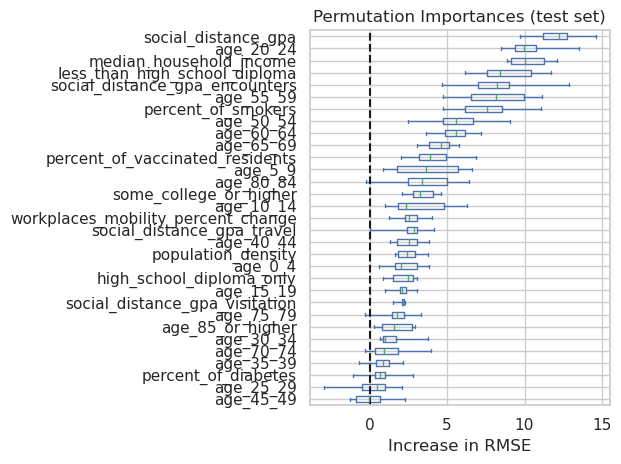

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

p = Pipeline(
    [
        ("regressor", model)
    ]
)
p.fit(X_train, y_train.values.ravel())

result = permutation_importance(
    p, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1, scoring = 'neg_root_mean_squared_error',
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=features[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Increase in RMSE")
ax.figure.tight_layout()

The numerical values of the increase in RMSE are reported below.

In [63]:
result.importances_mean[np.flip(np.abs(result.importances_mean).argsort())]

array([12.00630436, 10.19072721, 10.18111671,  8.80157112,  8.36619549,
        8.12265737,  7.55735911,  5.75577659,  5.54614774,  4.52260998,
        4.05136106,  3.78241918,  3.52142119,  3.37438579,  3.2148505 ,
        2.6562446 ,  2.54504041,  2.47415225,  2.46822411,  2.28781795,
        2.19704467,  2.15780112,  2.08719175,  1.69168539,  1.65617133,
        1.44825622,  1.28889535,  0.81615699,  0.78812454,  0.11634827,
        0.05235271])

# Summary of Results

- The OLS regression model was found to be unsuited for the purpose of feature importance due to violations of OLS assumptions.
- An optimized Decision Tree had better performance than the Null or OLS models.
- A MLP model performed better on the test data then all teh models except the Random Forest model.
- An optimized Random Forest model had the best performance of all the models.
- The was some overlap between the feature importance list generated by the Decision Tree and Random Forest models. This overlap will be reviewed in the video presentation and paper included in this distribution.

## See the paper and video for more analysis of these results.